# Final Project: Predicting Football Tables Early in the Season

## 1. Topic Introduction

### 1a. Why Soccer?

For many years now I have been a big fan of soccer, European club soccer and the international game in particular. I follow some other sports, but the so-called *Beautiful Game* garners the lionshare of my attention. Its fluidity, internationality and the high stakes that come with it being the world's most popular sport are what draw me to it. Like any other sport in the modern era, soccer generates a massive amount of data which is used to analyse the game by fans and clubs alike. While there is plenty of on-the-pitch data that one could look at, I have chosen to analyze data about the "table" or the standings of a league at a given point in time. 

Soccer determines a league champion differently then most American sports. Rather then a playoff tournament, the champion is determined entirely by regular season performance. The team with the most "points" based on wins, draws and losses at the end of the season will be crowned the league winner. If there are 20 teams in a league for example, each team will play all of the others twice for a total of 38 matches. Winning a match nets three points, drawing nets one and zero points are awarded for a loss. If two teams are tied in points, table position is determined by a statistic called goal differential (GD), which is simply *goals scored - goals against*. In soccer there also exists the concept of relegation, where the bottom two or three teams at the end of the season will be relegated from the league, or dropped down to play at a lower level and replaced with the best teams from that level in the previous season. 

### 1b. What are you analyzing?

I would like to see based on past data how well goal differential and points at earlier stages of the season can predict what position a team will finish in at the end of the season. So, if a team on matchday ten has 15 points and a -2 goal differential, what is the interval of positions in which they are most likely to finish? Surely based on the law of large numbers it will be on average close to their current position, but how accurate would a prediction be at different stages of the season? After the first matchday position and GD are probably not at all predictive, while on matchday 35 when the season is almost finished position is largely set. At what point in the season can current position predict final position within one palce? Within two places? 

This is a **regression task**, because I am trying to predict a variable (end of season position) based upon a number of features including current position, points, goal differential, wins, draws, losses and position last season. While end of season position is not a continuous variable, in the project guide it is stated that an **ordinal** discrete variables can also be the target of a regression task.

## 2. Qualification for Bonus

I am defining my own project problem in a space that interests me. I have not found information about how table position converges over the course of a season, so I will be answering a question that is not easy to answer with a quick google search. I could not find readily available data to solve the problem, so I created my own large dataset by writing a webscraper (see section 3 for more information). This took additional time and effort beyond simply downloading an existing CSV or other data file. While the problem itself is simple, it is novel and the results could be surprising.

**Project Repo Found Here: https://github.com/derek-watson14/3022-Project-dewa5122**

The repo contains the webscrapers written for the project as well as notebooks for each part.

## 3. Data Introduction


### 3a. Data Source and Citation

I was unable to find a readily available dataset that included weekly tables and not just end-of-season tables. I was able to find that information on a German soccer statistics website called *Transfermarkt.com*, but it was displayed in HTML tables such as the one below. 

#### Source Citation
```
Transfermarkt GmbH &amp; Co. KG. (n.d.). League - Table &amp; Results. Transfermarkt. Retrieved November 1, 2022, from https://www.transfermarkt.com/laliga/spieltagtabelle/wettbewerb/{league_code}?saison_id={year}&amp;spieltag={matchday}
```

<img src="./images/sample-table.png" height="600"/>

#### Creating the Dataset

Luckily, the tables were located at easy to parse URLs such as:
```
https://www.transfermarkt.com/laliga/spieltagtabelle/wettbewerb/GB1?saison_id=2017&spieltag=22
```
The league, season and matchday are all included as URL parameters. I could use a web scraping library like `Scrapy` to download the several thousand pages and another library like `BeautifulSoup` to parse the HTML and transform the data into a CSV row for each row of each table. Even the result of the season regarding relagation and Champions league qualification was codified by hex color code and could be translated to more data\*, which I called a team's "Fate".

Leagues will occasionally change the number of teams in the league, the last time such a change was made across Europe's "Big Five" leagues (the top level leagues of Spain, England, Germany, Italy, France) was in 2004. To keep league size consistent across years, I chose 2004 as my first year of analysis. So I downloaded 18 years of data total.

A few columns were added that weren't there in the original dataset, first a boolean column was added to indicate if that row belongs to a "Final Table" or a table from the end of the season. Second another column was added to indicate where the team from that row ended that season, called "EOS Position" (EOS meaning end of season). A final column was added called "Last Season" that indicates how a team finished the year before.

### 3b. Dataset Overview

In this section I will look at the general size of the data and print the schema which lists the data type and a description of each feature of the dataset.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

df = pd.read_csv('./data-retrieval/data/table_data.csv')
schema_df = pd.read_csv('./data-retrieval/data/data_schema.csv', index_col='Feature')

#### Size

The dataset contains 17 columns and 65736 rows

In [2]:
rows, columns = df.shape

print(f"Shape: {rows} rows, {columns} columns")

Shape: 65736 rows, 17 columns


#### Features

There are 9 categorical features and 8 numeric features in the dataset. Many of the categorical features, such as matchday or year or position are expressed as numbers, but are actually categorical. This should be clear with the table below.

In [3]:
schema_df['Feature Type'].value_counts()

Categorical    9
Numerical      8
Name: Feature Type, dtype: int64

In [4]:
schema_df

,Feature Description,Data Type,Feature Type
Feature,,,
Country,Country in which matches are played,String,Categorical
League,League in which matches are played,String,Categorical
Year,Starting year of season,Integer,Categorical
Club,Soccer club (team) for this row,String,Categorical
Matchday,Week of season for this row,Integer,Categorical
Position,Club's table position on this matchday,Integer,Categorical
Fate,Result of season in terms of international qua...,String,Categorical
Matches,Number of matches played by this matchday,Integer,Numerical
Wins,Matches won up to this matchday,Integer,Numerical


In [5]:
# Head of dataset
df.head(2)

,Country,League,Year,Club,Matchday,Position,Fate,Matches,Wins,Draws,Losses,Goals For,Goals Against,Goal Differential,Points,Final Table,EOS Position
0,Spain,La Liga,2004,Real Zaragoza,1,1,League Winner,1,1,0,0,3,1,2,3,False,12
1,Spain,La Liga,2004,Atlético de Madrid,1,2,Champions League,1,1,0,0,2,0,2,3,False,11


## 4. Data Cleaning

### 4a. Verifying dataset accuracy with summary stats

To quickly verify that this dataset is at least somewhat accurate, I can check that a number of summary statistics look how I would expect them to:

- The sum of the Wins column should be equal to the sum of the Losses column
- The sum of Wins, Losses and Draws should equal the sum of the matches
- The sum of the Goal Differential column should be equal to zero
- The count of teams at each position at the end of a season should be uniformly distributed
- **The total points at the end of the season should follow the equation: points = wins*3 + draws*1**

The first four points were satisfied as shown below, the last point was not and had to be handled by removing some rows from the dataset.

In [6]:
wins, losses, draws, matches = df['Wins'].sum(), df['Losses'].sum(), df['Draws'].sum(), df['Matches'].sum()
print(f"Total wins: {wins} | Total losses: {losses} | Equal? {'Yes' if wins == losses else 'No'}\n")
print(f"Wins + Losses + Draws: {wins+losses+draws} | Matches: {matches} | Equal? {'Yes' if wins+losses+draws == matches else 'No'}\n")
print(f"Goal differential sum: {df['Goal Differential'].sum()}\n")
print("Total number teams in each position at end of each season (for four 20-team leagues):")
print(df[(df['Country'].isin(["England", "France", "Italy", "Spain"])) & (df['Matchday'] == 38)]['Position'].value_counts().sort_index())

Total wins: 463998 | Total losses: 463998 | Equal? Yes

Wins + Losses + Draws: 1258700 | Matches: 1258700 | Equal? Yes

Goal differential sum: 0

Total number teams in each position at end of each season (for four 20-team leagues):
1     72
2     72
3     72
4     72
5     72
6     72
7     72
8     72
9     72
10    72
11    72
12    72
13    72
14    72
15    72
16    72
17    72
18    72
19    72
20    72
Name: Position, dtype: int64


### 4b. Removing unusual/erroneuos rows

From the data printed above it's clear that most of those mathematical checks come back good, but one does not:
- **The total points at the end of the season should follow the equation: points = wins*3 + draws*1**

In [7]:
eos_tables = df[df["Final Table"] == True]

more_pts = eos_tables[(eos_tables['Points'] > ((eos_tables['Wins'] * 3) + (eos_tables['Draws'] * 1)))]
less_pts = eos_tables[(eos_tables['Points'] < ((eos_tables['Wins'] * 3) + (eos_tables['Draws'] * 1)))]

print("Clubs with MORE points than expected at EOS: %i" % len(more_pts))
print("Clubs with LESS points than expected at EOS: %i" % len(less_pts))

Clubs with MORE points than expected at EOS: 2
Clubs with LESS points than expected at EOS: 24


So, there are 2 clubs with more points than they should have at the end of the season, and 24 clubs with less points than they should have at the end of the season. 

I looked into some individual cases by comparing the Transfermarkt data to the Wikipedia data for that league in that season and found that reduced points were often connected to scandals, fan misconduct or club misconduct in which teams were penalized points causing thier final table position to not perfectly reflect thier performances.

One example is Juventus in 2005, who won the league but were relegated and awarded 0 points after a cheating scandal was exposed:

In [8]:
juve05 = eos_tables[(eos_tables["Club"] == "Juventus FC") & (eos_tables["Year"] == 2005)]
juve05[["Country", "League", "Year", "Club", "Matchday", "Wins", "Draws", "Losses", "Points", "EOS Position"]]

,Country,League,Year,Club,Matchday,Wins,Draws,Losses,Points,EOS Position
42439,Italy,Serie A,2005,Juventus FC,38,27,10,1,0,20


While one solution here would be to recalculate where Juventus would finish based on their *actual* calcuated points total compared to other Italian clubs in 2005, doing so for every instance of the dataframe would be assuming that all 26 cases of incorrect points totals would be making the assumption that all instances of incorrect point total are real-world, intentional corrections unrelated to on field play. Without looking at all 26 cases individually, I can't confirm that that assumption is true, and I simply don't have the time to read the Wikipedia article for each instance. In addition to this if points were 

Luckily the 26 incorrect values represent <1.5% of the total dataset, so I can simply remove them and have a clean dataset that is effectively the same size. Doing so invalidates some of the verifications done in *4a*, but that will not effect my project as long as the verifications were originally true, thus removing those rows is the right decision here.

When building the final version of my project if I have extra time I may try to hand correct these errors, but for now this is the best course of action

In [9]:
print(f"Percentage of rows with incorrect point totals: {((len(more_pts) + len(less_pts)) / len(eos_tables) * 100)}%")

Percentage of rows with incorrect point totals: 1.473922902494331%


In [10]:
# Clean dataframe
cldf = df[(df['Points'] == ((df['Wins'] * 3) + (df['Draws'] * 1)))]

# Remaining rows
len(cldf)

64748

In addition to removing those rows, I think the `Fate` column is irrelevant to the project and can be removed because I am not doing a classification project but a regression project with ordinal discrete variables. Also, now that `Matches` has been confirmed to be accurate, it is redundant with `Matchday` and can also be removed. 

In [11]:
cldf = cldf.drop(['Fate','Matches'], axis=1)
cldf.head(2)

,Country,League,Year,Club,Matchday,Position,Wins,Draws,Losses,Goals For,Goals Against,Goal Differential,Points,Final Table,EOS Position
0,Spain,La Liga,2004,Real Zaragoza,1,1,1,0,0,3,1,2,3,False,12
1,Spain,La Liga,2004,Atlético de Madrid,1,2,1,0,0,2,0,2,3,False,11


## 5. Exploratory Data Analysis

I decided to look at exploratory data analysis in two phases in my project. First looking at the structure of data from end of season tables through histograms and correlation, second looking at how earlier season features correlate with end of season position. For example, how much does current position correlate with end of season position for each matchday. There are a number of visualizations below exploring these topics. 

Note: for this exploratory analysis, I am ommitting looking at the German league. Since the German league only has 18 teams and 34 matchdays, it throws off correlations for the dataset as a whole. For example in Germany table position at matchday 34 will have a correlation coefficient of 1, because MD 34 is the final matchday. In the other 4 leagues it will be high but slightly lower, because they have 34 matchdays.

### 5a. Looking at end of season statistics

As one would expect, at the end of the season points, wins, goals for and goal differential correlate negatively\* with position while losses and goals against correlate positively.

\* *Note: A negative correlation with position counterintuitively means that the statistic makes position better, while a positive correlation makes position worse. This is because a low number is desirable for position, so when wins goes UP, position is expected to go DOWN.*

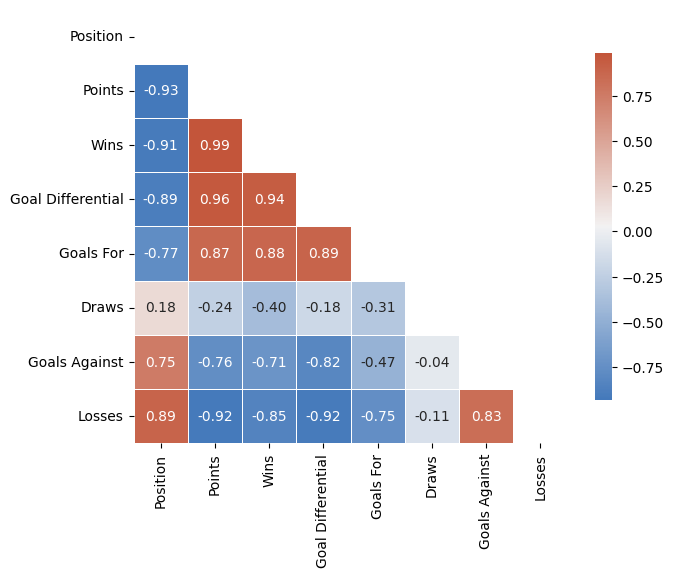

In [32]:
import seaborn as sns

# Remove German league (for now)
cldf = cldf[cldf['Country'] != "Germany"]

# Take only final table data
cleos_tables = cldf[cldf['Final Table'] == True]

# Take only numerical categories
cleos_corr_matrix = cleos_tables[['Position', 'Points', 'Wins', 'Goal Differential', 'Goals For', 'Draws', 'Goals Against', 'Losses', ]]

# Compute correlation matrix
corr = cleos_corr_matrix.corr()

# Generate mask for upper right triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up figure
f, ax = plt.subplots(figsize=(7, 9))

# Generate diverging color map
cmap = sns.diverging_palette(250, 20, as_cmap=True)

# Draw heatmap with settings
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

That information was obvious, but it's good to see visually. We can see that some statistics, like goals for and against don't correlate perfectly with position. Some teams can of course concede many goals but still do well on the season because of a strong offense or have the inverse be true.

As you can see, teams have finished in first with anywhere from around 50 to 120 goals, but a correlation can still be observed.

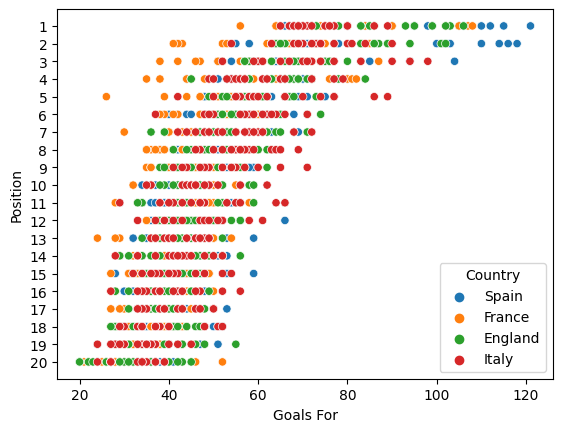

In [13]:
cleos_position = cleos_tables["Position"]

cleos_gf = cleos_tables["Goals For"]

gfp = sns.scatterplot(x=cleos_gf, y=cleos_position, hue=cleos_tables["Country"])
plt.yticks(np.linspace(1,20,20))
gfp.invert_yaxis()

As one can see below, goal differential is normally distributed at the end of the season around 0.

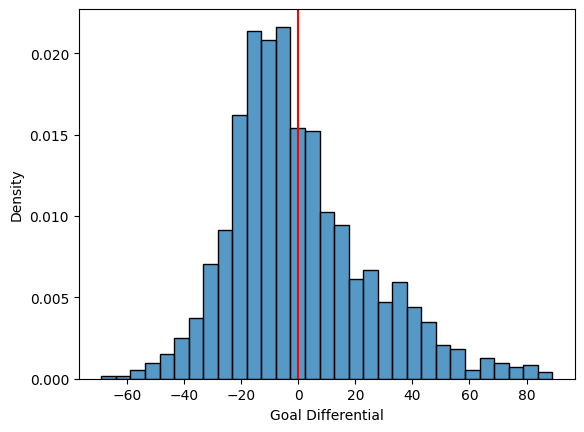

In [31]:
cleos_gd = cleos_tables["Goal Differential"]

sns.histplot(cleos_gd, stat='density');
plt.axvline(cleos_gd.mean(), c='r');

### 5b. Looking at how well early season can predict late season

All of the above is fairly obvious, but the end goal of the project is to see how well only common table statistics can be used to predict end of season position. One way to do this is to group all teams by table position then by matchday and display the average distance a team is at that point in the season from thier final position as an absolute value.

For example, for all third place teams on matchday five the average end of season position is actually +-2.76 positions. As the season goes on, the current position reflects more closely the end of season position. On the final matchday this difference should be 0.

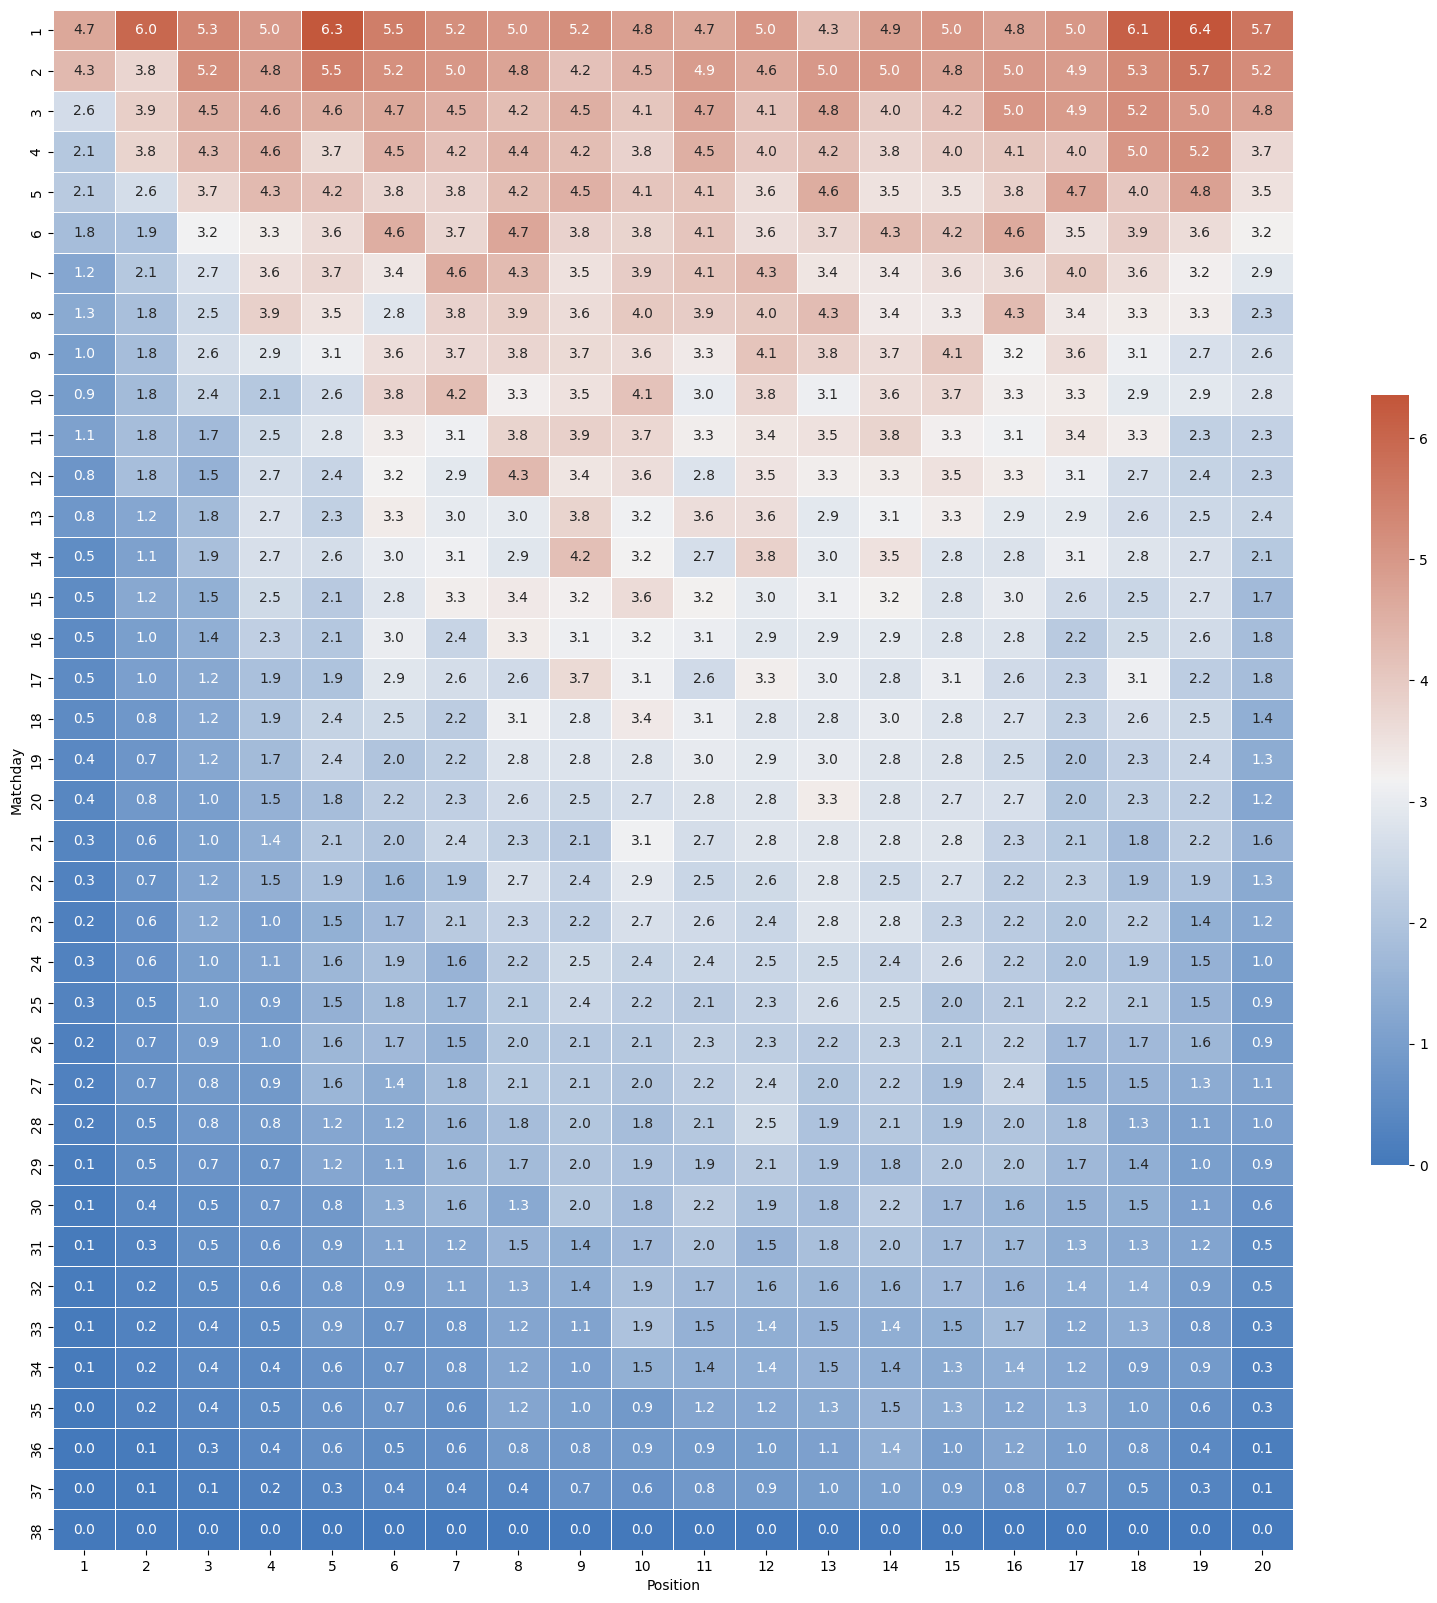

In [37]:
relevant = cldf[['Matchday', 'Position', 'EOS Position']]
pd.options.mode.chained_assignment = None
relevant["Position Difference"] = relevant.apply(lambda row: np.abs(row['EOS Position'] - row['Position']), axis=1)
relevant.drop('EOS Position', axis=1)

grouped = relevant.groupby(['Matchday', 'Position'], as_index=False).mean()
pivoted = grouped.pivot('Matchday', 'Position', 'Position Difference')

pivoted

# Set up figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate diverging color map
cmap = sns.diverging_palette(250, 20, as_cmap=True)

# Draw heatmap with settings
sns.heatmap(pivoted, cmap=cmap, annot=True, fmt='.1f',
            linewidths=.5, cbar_kws={"shrink": .5});

As you can see from the chart, on average teams are within one position of thier final position across the table only by matchday 37, one before the final. Teams are within 2 positions of thier final position by matchday 31. 

Teams are more solidified in their positions at the top and bottom of the table than in the middle, where teams move around more frequently. For example by matchday 14 teams in first only moved 0.5 positions away on average, meanwhile teams in 9th on that same matchday finished on average 4.2 positions away from 9th. 

The challenge of this project will be to see if I can predict end of season position earlier in the season using additional statistics like goal differential and points. Since all of these are closely correlated with wins, it may be difficult to improve too much on the simple prediction that a team in X position will finish in X position, but that is what I want to find out.

## 6. Model Approach

#### Which models will I try?

Since I am performing a regression task on an ordinal discrete random variable, I will need to try models that can perform *ordinal regression*. Such models include the Generalized Linear Model which can be applied in a number of different ways depending on the link function used. This is a true regression technique that can be adapted to handle a quasi-classification problem like ordinal regression. Another option would be to use ordered logistic regression, which is more of a classification technique that can also be used for ordinal regression.

As of writing I haven't had a ton of time to research the models so this is my starting point. Since ordinal regression is kind of in between a classification and regression problem, using a special form of the generalized linear model or ordered logistic regression (a special form of logisitic regression) is possible. I will need to read further and experiment with both to determine what is best for this project.